# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `07_MLmodels.ipynb`                        |
| Purpose  | ML models                |

(todo: description)

# 1 - Setup

In [1]:
# imports from Python standard library

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas

In [2]:
!pip install demoji
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import demoji
import seaborn as sns
import nltk
from datetime import date
import regex as re
import pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 1.3 MB/s eta 0:00:00


In [145]:
#pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
#models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
#evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV
# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif

%matplotlib inline

In [3]:
#Colab Specific workflow - remove for github
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# pandas options
pd.set_option('display.max_colwidth', None)

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [ ]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [ ]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

## Load 06_Feature_Engineering Dataset English Tweets Only

Full dataset, as prepared by `06_feature_engineering.ipynb`, will be loaded as "`df`".

In [5]:
#Colab Specific workflow - remove for github

#Google Drive url for data file
file_folder = '/content/gdrive/MyDrive/Grad School/DSCI592/data/'

In [9]:
df= pd.read_parquet(file_folder + '06data_final_en.parquet.gz')

In [10]:
df.columns

Index(['updates', 'is_retweet', 'has_url', 'emoji_count', 'following_ratio',
       'class_numeric', 'RUS_lett_count', 'emoji_flagUS', 'emoji_police',
       'emoji_check', 'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_troll', 'unknown_location', 'multi_authors'],
      dtype='object')

In [12]:
df['is_retweet']=df['is_retweet'].astype(int)

## 2 - Downsampling and Test Train Split

50/50 Split Sub-Sample

In [14]:
df_sample100k = df.groupby('class_numeric', group_keys=False).apply(lambda x: x.sample(50000, random_state = 42))

In [17]:
df_sample100k['class_numeric'].value_counts().div(len(df_sample100k.index))

0    0.5
1    0.5
Name: class_numeric, dtype: float64

In [18]:
BYTES_PER_GIGABYTE = 10**9  # using IEC-recommended conversion; https://en.wikipedia.org/wiki/Gigabyte#Base_10_(decimal)

df_full_size_gb = df.memory_usage(deep=True).sum() / BYTES_PER_GIGABYTE
df_size_gb = df_sample100k.memory_usage(deep=True).sum() / BYTES_PER_GIGABYTE

print(f"Full dataframe size:\t{df_full_size_gb:8.2f} GB")
print(f"Sampled dataframe size:\t{df_size_gb:8.2f} GB\n")

print(f"Full dataframe rows:\t{len(df.index):>11,}")
print(f"Sampled dataframe rows:\t{len(df_sample100k.index):>11,}\n")

class_split_full = [f"{x*100:0.1f}%" for x in df['class_numeric'].value_counts().div(len(df.index)).tolist()]
class_split_samp = [f"{x*100:0.1f}%" for x in df_sample100k['class_numeric'].value_counts().div(len(df_sample100k.index)).tolist()]

print(f"Full df class split:\t{class_split_full}")
print(f"Sampled df class split:\t{class_split_samp}\n")

Full dataframe size:	    0.46 GB
Sampled dataframe size:	    0.01 GB

Full dataframe rows:	  3,596,578
Sampled dataframe rows:	    100,000

Full df class split:	['58.1%', '41.9%']
Sampled df class split:	['50.0%', '50.0%']



Random Sub-sample


In [ ]:
# subset parameters
sample_fraction = 0.10  # within range (0.0, 1.0)
random_seed = 3         # for reproducability, and "the number of the counting shall be three"

# generate sample
df_sample10pct = df.sample(frac=sample_fraction, random_state=random_seed).copy()

In [ ]:
df_sample10pct['class_numeric'].value_counts().div(len(df_sample10pct.index))

In [20]:
target = ['class_numeric']
columns_without_target = list(df_sample100k[df_sample100k.columns.difference(target)])
x_df = df_sample100k[columns_without_target]
y_df = df_sample100k['class_numeric']

In [ ]:
BYTES_PER_GIGABYTE = 10**9  # using IEC-recommended conversion; https://en.wikipedia.org/wiki/Gigabyte#Base_10_(decimal)

df_full_size_gb = df.memory_usage(deep=True).sum() / BYTES_PER_GIGABYTE
df_size_gb = df_sample10pct.memory_usage(deep=True).sum() / BYTES_PER_GIGABYTE

print(f"Full dataframe size:\t{df_full_size_gb:8.2f} GB")
print(f"Sampled dataframe size:\t{df_size_gb:8.2f} GB\n")

print(f"Full dataframe rows:\t{len(df.index):>11,}")
print(f"Sampled dataframe rows:\t{len(df_sample10pct.index):>11,}\n")

class_split_full = [f"{x*100:0.1f}%" for x in df['class_numeric'].value_counts().div(len(df.index)).tolist()]
class_split_samp = [f"{x*100:0.1f}%" for x in df_sample10pct['class_numeric'].value_counts().div(len(df_sample10pct.index)).tolist()]

print(f"Full df class split:\t{class_split_full}")
print(f"Sampled df class split:\t{class_split_samp}\n")

In [139]:
#with stratify
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle= True, stratify= y_df, random_state=46) 

In [83]:
#without stratify
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle= True, random_state=46) 

In [79]:
x_train.shape

(80000, 16)

In [34]:
x_train.describe()

,RUS_lett_count,emoji_check,emoji_collision,emoji_count,emoji_exclamation,emoji_fist,emoji_flagUS,emoji_police,emoji_prohibited,emoji_troll,following_ratio,has_url,is_retweet,multi_authors,unknown_location,updates
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,0.001775,0.000687,0.000325,0.071688,0.000588,0.000675,0.001463,0.000638,0.000112,0.003762,0.761135,0.619125,0.316937,0.064550,0.112287,6.006338e+03
std,0.316027,0.026211,0.018025,0.580993,0.024231,0.025972,0.038215,0.025241,0.010606,0.061224,3.092489,0.485605,0.465286,0.245732,0.315722,1.937644e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007722,0.000000,0.000000,0.000000,0.000000,5.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.263332,1.000000,0.000000,0.000000,0.000000,4.110000e+02
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.875049,1.000000,1.000000,0.000000,0.000000,4.974000e+03
max,88.000000,1.000000,1.000000,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,321.333333,1.000000,1.000000,1.000000,1.000000,3.062703e+06


### 3- Sklearn Pipelines

Min Max Scaler Pipeline 

In [62]:
#create pipeline to use MinMax Scaler
full_pipeline = make_column_transformer(
    (MinMaxScaler(), columns_without_target),
    remainder='passthrough', verbose_feature_names_out=False,
        sparse_threshold=0)

In [100]:
#apply fit_transform on x_train
x_train = pd.DataFrame(full_pipeline.fit_transform(x_train),columns=full_pipeline.get_feature_names_out())

In [101]:
x_train.describe()

,RUS_lett_count,emoji_check,emoji_collision,emoji_count,emoji_exclamation,emoji_fist,emoji_flagUS,emoji_police,emoji_prohibited,emoji_troll,following_ratio,has_url,is_retweet,multi_authors,unknown_location,updates
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.000020,0.000687,0.000325,0.001258,0.000588,0.000675,0.001463,0.000637,0.000112,0.003762,0.002369,0.619125,0.316937,0.064550,0.112287,0.001961
std,0.003591,0.026211,0.018025,0.010193,0.024231,0.025972,0.038215,0.025241,0.010606,0.061224,0.009624,0.485605,0.465286,0.245732,0.315722,0.006327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000,0.000002
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000819,1.000000,0.000000,0.000000,0.000000,0.000134
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002723,1.000000,1.000000,0.000000,0.000000,0.001624
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
#transform x_test
x_test = pd.DataFrame(full_pipeline.transform(x_test), columns= full_pipeline.get_feature_names_out())

StandardScaler Pipeline

In [112]:
#alt pipeline for StandardScaler
full_pipeline2 = make_column_transformer(
    (StandardScaler(), columns_without_target),
    remainder='passthrough', verbose_feature_names_out=False,
        sparse_threshold=0)

In [140]:
#apply fit_transform on x_train
x_train = pd.DataFrame(full_pipeline2.fit_transform(x_train),columns=full_pipeline2.get_feature_names_out())

In [141]:
#transform x_test
x_test = pd.DataFrame(full_pipeline2.transform(x_test), columns= full_pipeline2.get_feature_names_out())

In [115]:
x_train.describe()

,RUS_lett_count,emoji_check,emoji_collision,emoji_count,emoji_exclamation,emoji_fist,emoji_flagUS,emoji_police,emoji_prohibited,emoji_troll,following_ratio,has_url,is_retweet,multi_authors,unknown_location,updates
count,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04
mean,5.595524e-18,4.440892e-18,-1.865175e-18,-1.394440e-17,5.861978e-18,-3.907985e-18,-1.403322e-17,-2.380318e-17,-8.881784e-19,2.167155e-17,-5.195844e-17,-9.290346e-17,4.356515e-17,9.965362e-17,1.714184e-17,-4.600764e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-5.616643e-03,-2.622924e-02,-1.803069e-02,-1.233887e-01,-2.424552e-02,-2.598954e-02,-3.827064e-02,-2.525681e-02,-1.060720e-02,-6.145494e-02,-2.461254e-01,-1.274964e+00,-6.811717e-01,-2.626865e-01,-3.556555e-01,-3.099834e-01
25%,-5.616643e-03,-2.622924e-02,-1.803069e-02,-1.233887e-01,-2.424552e-02,-2.598954e-02,-3.827064e-02,-2.525681e-02,-1.060720e-02,-6.145494e-02,-2.436284e-01,-1.274964e+00,-6.811717e-01,-2.626865e-01,-3.556555e-01,-3.097253e-01
50%,-5.616643e-03,-2.622924e-02,-1.803069e-02,-1.233887e-01,-2.424552e-02,-2.598954e-02,-3.827064e-02,-2.525681e-02,-1.060720e-02,-6.145494e-02,-1.609729e-01,7.843358e-01,-6.811717e-01,-2.626865e-01,-3.556555e-01,-2.887719e-01
75%,-5.616643e-03,-2.622924e-02,-1.803069e-02,-1.233887e-01,-2.424552e-02,-2.598954e-02,-3.827064e-02,-2.525681e-02,-1.060720e-02,-6.145494e-02,3.683576e-02,7.843358e-01,1.468059e+00,-2.626865e-01,-3.556555e-01,-5.327833e-02
max,2.784533e+02,3.812539e+01,5.546101e+01,9.798515e+01,4.124473e+01,3.847703e+01,2.612969e+01,3.959328e+01,9.427560e+01,1.627208e+01,1.036622e+02,7.843358e-01,1.468059e+00,3.806818e+00,2.811710e+00,1.577542e+02


In [128]:
x_train.head()

,RUS_lett_count,emoji_check,emoji_collision,emoji_count,emoji_exclamation,emoji_fist,emoji_flagUS,emoji_police,emoji_prohibited,emoji_troll,following_ratio,has_url,is_retweet,multi_authors,unknown_location,updates
0,-0.005617,-0.026229,-0.018031,-0.123389,-0.024246,-0.02599,-0.038271,-0.025257,-0.010607,-0.061455,0.029182,-1.274964,-0.681172,-0.262687,-0.355656,0.319032
1,-0.005617,-0.026229,-0.018031,-0.123389,-0.024246,-0.02599,-0.038271,-0.025257,-0.010607,-0.061455,0.720301,0.784336,-0.681172,3.806818,-0.355656,-0.281598
2,-0.005617,-0.026229,-0.018031,-0.123389,-0.024246,-0.02599,-0.038271,-0.025257,-0.010607,-0.061455,-0.076785,-1.274964,-0.681172,-0.262687,-0.355656,-0.309983
3,-0.005617,-0.026229,-0.018031,-0.123389,-0.024246,-0.02599,-0.038271,-0.025257,-0.010607,-0.061455,0.016778,-1.274964,1.468059,-0.262687,-0.355656,-0.220338
4,-0.005617,-0.026229,-0.018031,-0.123389,-0.024246,-0.02599,-0.038271,-0.025257,-0.010607,-0.061455,-0.100183,0.784336,-0.681172,-0.262687,-0.355656,0.152643


### 4 - Feature Importance

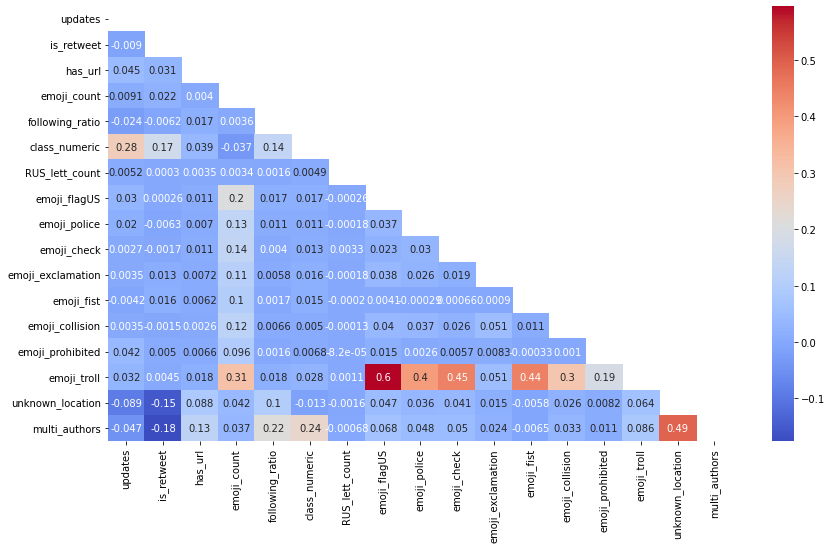

In [61]:
#correlation heat map
correlation_matrix_heatmap = df.corr()

# remove duplicate boxes in upper triangle
mask = np.zeros_like(correlation_matrix_heatmap)
mask[np.triu_indices_from(mask)] = True

# plot the correlation heat map to see connections amoung the dataset

fig, ax = plt.subplots(figsize=(14,8))   
ax = sns.heatmap(correlation_matrix_heatmap, 
    xticklabels = correlation_matrix_heatmap.columns, 
    yticklabels = correlation_matrix_heatmap.columns, 
    annot = True, mask = mask, cmap= 'coolwarm')

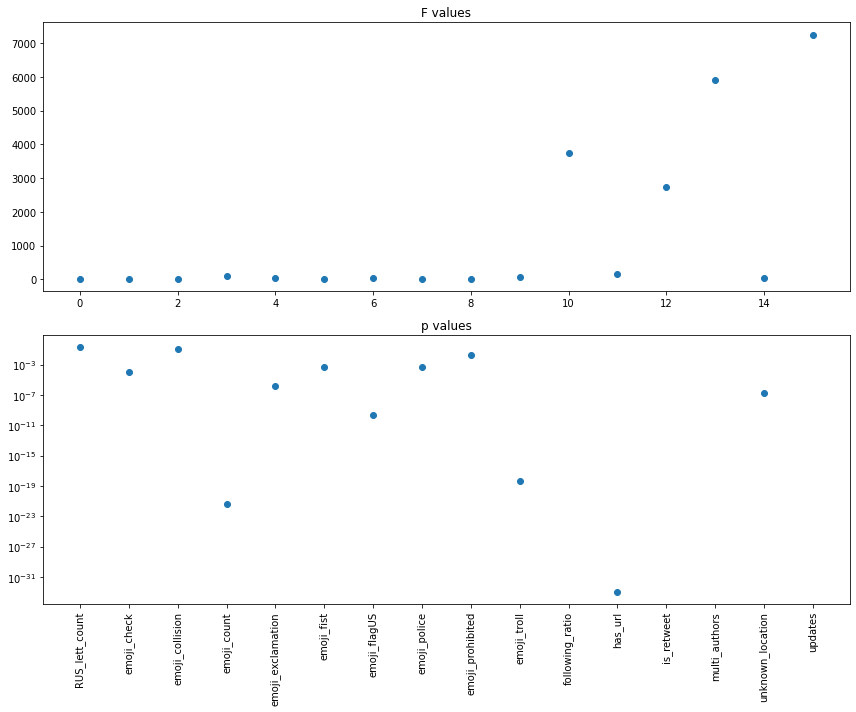

In [40]:
from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(x_train, y_train)

fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax[0].set_title("F values")
ax[0].plot(f_values, 'o')
ax[1].set_title("p values")
ax[1].plot(p_values, 'o')
ax[1].set_yscale("log")

ax[1].set_xticks(range(x_train.shape[1]))
ax[1].set_xticklabels(x_train.columns, rotation=90);
fig.tight_layout()

## 5 Dummy Classifier

In [53]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [54]:
dummy.fit(x_train, y_train)
dummy_pred = dummy.predict(x_test)
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))

Accuracy Score: 0.5035


### 5 - Logistic Regression Classifier using StandardScaler Pipeline

In [116]:
lr = LogisticRegression(
    random_state=42,
    tol=0.0001,
    C=0.5,
    max_iter=1e3
)
lr.fit(x_train, y_train)

LogisticRegression(C=0.5, max_iter=1000.0, random_state=42)

In [117]:
#view how many iterations were needed
lr.n_iter_

array([48], dtype=int32)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


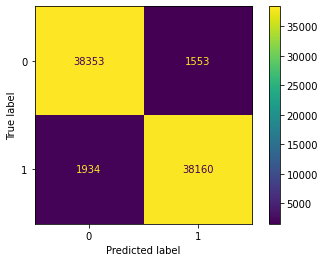

In [118]:
plot_confusion_matrix(lr, x_train, y_train)

In [119]:
print("TRAIN Scores")
print(f'Accuracy score: {round(accuracy_score(y_train, lr.predict(x_train)), 3)}')
print(f'Precision score: {round(precision_score(y_pred=lr.predict(x_train), y_true=y_train),3)}')
print(f'Recall score: {round(recall_score(y_pred=lr.predict(x_train), y_true=y_train),3)}')
print(f'ROC/AUC score: {round(roc_auc_score(y_train, lr.predict_proba(x_train)[:,1]),3)}')

TRAIN Scores
Accuracy score: 0.956
Precision score: 0.961
Recall score: 0.952
ROC/AUC score: 0.987


In [120]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train)
y_train_scores = lr.decision_function(x_train)

In [121]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores)

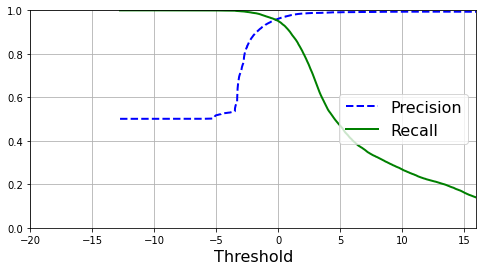

In [122]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-20, 16, 0, 1])             

plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

LR Model Test Predictions

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


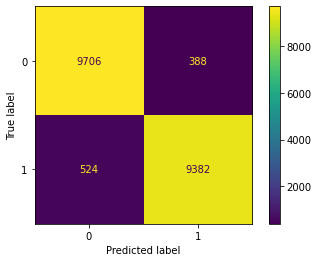

In [123]:
#Predict on Test
lr_predict = lr.predict(x_test)
plot_confusion_matrix(lr, x_test, y_test)

In [124]:
#get TEST Scores
#score = lr.score(x_test,y_test)
score = accuracy_score(y_test, lr.predict(x_test))
#Precision score for test
p_score = precision_score(lr_predict, y_test)
#recall for test
r_score = recall_score(lr_predict, y_test)
#ROC/AUC 
roc_auc = roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])

print('TEST')
print('Accuracy:',round(score,3))
print('Precision:',round(p_score,3))
print('Recall:',round(r_score,3))
print('ROC/AUC:', round(roc_auc, 3))

TEST
Accuracy: 0.954
Precision: 0.947
Recall: 0.96
ROC/AUC: 0.985


In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test,lr_predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10094
           1       0.96      0.95      0.95      9906

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



#### Identifying Features of Importance

In [125]:
coefs_features = list(zip(lr.coef_[0],x_train.columns))
for i in sorted(coefs_features):
  print(i)

(-0.5763589937829828, 'unknown_location')
(-0.16187451023268637, 'emoji_count')
(-0.03767625595412224, 'emoji_prohibited')
(-0.0194258136902476, 'emoji_police')
(-0.01846700964353045, 'emoji_troll')
(-0.004831610050307347, 'emoji_flagUS')
(0.00016883639738685216, 'RUS_lett_count')
(0.004115292428374152, 'emoji_collision')
(0.00696397511053704, 'emoji_check')
(0.024237449257547245, 'emoji_exclamation')
(0.028014460339691506, 'emoji_fist')
(0.08593401732625945, 'has_url')
(0.24556254496703067, 'is_retweet')
(2.542462033155453, 'multi_authors')
(7.747971762304709, 'updates')
(14.197149527534263, 'following_ratio')


Most important features identified are:
1.   Following Ratio
2.   Updates
3.   Multi Authors

### 6 - Decision Tree Classifier w/ StandardScaler

In [126]:
dt = DecisionTreeClassifier(
    random_state=42,
    min_samples_split=100,
    max_depth=6
)
dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=100, random_state=42)

In [127]:
print("TRAIN Scores")
print(f'Accuracy score: {round(accuracy_score(y_train, dt.predict(x_train)), 3)}')
print(f'Precision score: {round(precision_score(y_pred=dt.predict(x_train), y_true=y_train),3)}')
print(f'Recall score: {round(recall_score(y_pred=dt.predict(x_train), y_true=y_train),3)}')
print(f'ROC/AUC score: {round(roc_auc_score(y_train, dt.predict_proba(x_train)[:,1]),3)}')

TRAIN Scores
Accuracy score: 0.992
Precision score: 0.991
Recall score: 0.993
ROC/AUC score: 0.998


In [97]:
#get TEST Scores
score = accuracy_score(y_test, dt.predict(x_test))
#Precision score for test
p_score = precision_score(dt.predict(x_test), y_test)
#recall for test
r_score = recall_score(dt.predict(x_test), y_test)
#ROC/AUC 
roc_auc = roc_auc_score(y_test, dt.predict_proba(x_test)[:,1])

print('TEST')
print('Accuracy:',round(score,3))
print('Precision:',round(p_score,3))
print('Recall:',round(r_score,3))
print('ROC/AUC:', round(roc_auc, 3))

TEST
Accuracy: 0.991
Precision: 0.992
Recall: 0.99
ROC/AUC: 0.997


### 7 - XGBoost Classifier using Standard Scaler

In [143]:
# Init classifier
xgb_cl = XGBClassifier()

# Fit
xgb_cl.fit(x_train, y_train)

# Predict
preds = xgb_cl.predict(x_test)

# Score
accuracy_score(y_test, preds)

0.9917

#### Using GridSearchCV

In [144]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [147]:
# Init classifier
xgb_cl = XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(x_train, y_train)

In [148]:
grid_cv.best_score_

0.9993628579991647

In [149]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [150]:
#save best params to param_grid
param_grid["colsample_bytree"] = [0.5]
param_grid["gamma"]= [0]
param_grid["learning_rate"] = [0.1]
param_grid["max_depth"]= [7]
param_grid["reg_lambda"]=[0]
param_grid["scale_pos_weight"]=[1]
param_grid["subsample"]= [0.8]

In [154]:
grid_cv_2 = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(x_train, y_train)


In [155]:
grid_cv_2.best_score_

AttributeError: ignored